In [110]:
import numpy as np
import tensorflow as tf
from  tensorflow.keras.layers import *
import matplotlib as mpl
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K
import random


In [111]:
num_classes = 10
lr = 0.95
margin = 0.5

In [112]:
# utils function
def create_dataset(x,labels):
  x = x.astype(float)/255
  indices = [np.asarray(labels==i).nonzero()[0] for i in range(num_classes)]
  pairs = []
  pair_labels = []
  mn_len = np.min([len(indice) for indice in indices])
  for cls in range(num_classes):
    for i in range(mn_len-1):
      x1,x2 = x[indices[cls][i]],x[indices[cls][i+1]]
      pairs += [[x1,x2]]
      indice = cls
      inc = random.randrange(1, 10)
      indice = (cls + inc) % num_classes
      x1,x2 = x[indices[cls][i]],x[indices[indice][i]]
      pairs += [[x1,x2]]
      pair_labels += [1.0,0.0]
  return np.array(pairs),np.array(pair_labels)

def show_pairs(pair):
  pair = np.swapaxes(pair,0,1)
  pair = np.reshape(pair,(-1,pair.shape[1]*pair.shape[2]))
  show_image(pair)

def show_image(img):
  plt.figure()
  plt.gray()
  plt.imshow(img)
  plt.grid('off')

In [113]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
tr_pairs,tr_labels = create_dataset(x_train,y_train)
ts_pairs,ts_labels = create_dataset(x_test,y_test)

1.0
0.0


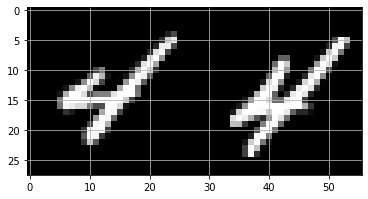

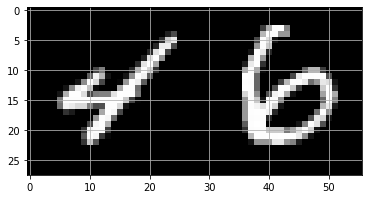

In [114]:
idx_show = 50000
show_pairs(tr_pairs[idx_show])
print(tr_labels[idx_show])
show_pairs(tr_pairs[idx_show+1])
print(tr_labels[idx_show+1])


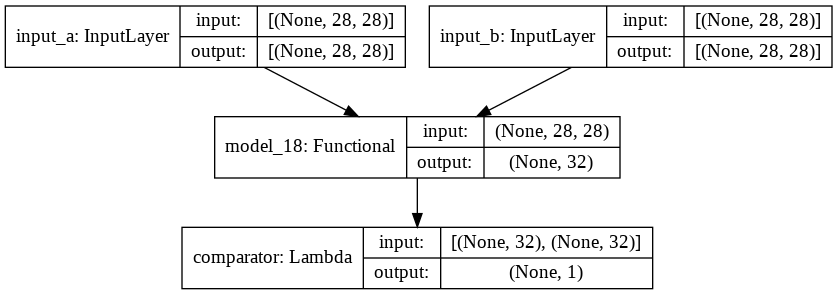

In [115]:
def Siamese_network(base_network):
  def dist(vecs):
    v1,v2 = vecs
    d = K.sum(K.square(v1-v2),axis=1,keepdims=True)
    return K.maximum(K.sqrt(d),K.epsilon())
  input_shape = base_network.layers[0].input_shape[0]
  input_shape = (input_shape[1],input_shape[2])
  inp_a = Input(shape=input_shape,name='input_a')
  inp_b = Input(shape=input_shape,name='input_b')
  vec_a = base_network(inp_a)
  vec_b = base_network(inp_b)
  out = Lambda(dist,name='comparator')([vec_a,vec_b])
  return tf.keras.models.Model(inputs=[inp_a,inp_b],outputs=out)

def create_base_network(input_shape):
  inp = Input(shape=input_shape,name='input')
  x = Flatten()(inp)
  x = Dense(128,'relu')(x)
  x = Dropout(0.4)(x)
  x = Dense(64,activation = 'relu',name='Dense_2')(x)
  #x = Dropout(0.1)(x)
  x = Dense(32,activation = 'relu',name='Dense_3')(x)
  return tf.keras.models.Model(inputs=inp,outputs=x)

shape = (28,28)
base_network = create_base_network(shape)
siamese = Siamese_network(base_network)
tf.keras.utils.plot_model(
    siamese,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)


  


In [116]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

opt = tf.keras.optimizers.RMSprop()
loss = contrastive_loss_with_margin(margin=margin)
siamese.compile(optimizer=opt,loss=loss)

In [103]:
history = siamese.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_labels, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_labels))

Epoch 1/20
847/847 [==============================] - 8s 8ms/step - loss: 0.1230 - val_loss: 0.0674
Epoch 2/20
847/847 [==============================] - 7s 8ms/step - loss: 0.0680 - val_loss: 0.0483
Epoch 3/20
847/847 [==============================] - 7s 8ms/step - loss: 0.0547 - val_loss: 0.0419
Epoch 4/20
847/847 [==============================] - 7s 8ms/step - loss: 0.0472 - val_loss: 0.0376
Epoch 5/20
847/847 [==============================] - 7s 9ms/step - loss: 0.0422 - val_loss: 0.0337
Epoch 6/20
847/847 [==============================] - 6s 8ms/step - loss: 0.0391 - val_loss: 0.0325
Epoch 7/20
847/847 [==============================] - 7s 8ms/step - loss: 0.0370 - val_loss: 0.0327
Epoch 8/20
847/847 [==============================] - 7s 8ms/step - loss: 0.0358 - val_loss: 0.0320
Epoch 9/20
847/847 [==============================] - 7s 8ms/step - loss: 0.0341 - val_loss: 0.0315
Epoch 10/20
847/847 [==============================] - 6s 8ms/step - loss: 0.0326 - val_loss: 0.0302

In [117]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

loss = siamese.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_labels)

y_pred_train = siamese.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_labels, y_pred_train)

y_pred_test = siamese.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_labels, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

557/557 [==============================] - 3s 4ms/step - loss: 0.2665
Loss = 0.26646244525909424, Train Accuracy = 0.554040590405904 Test Accuracy = 0.5768799102132436


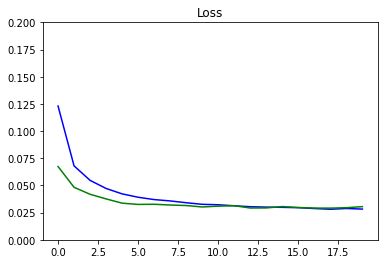

In [118]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [119]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)


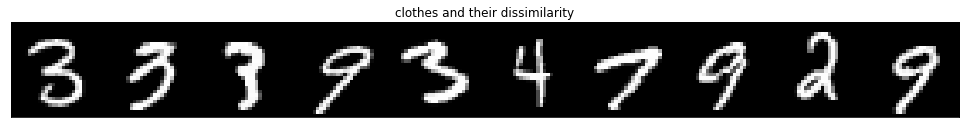

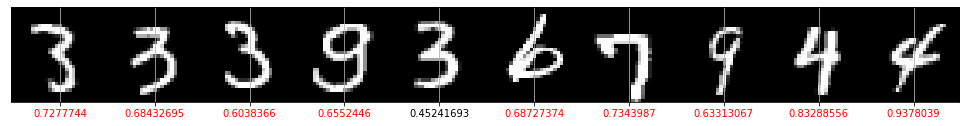

In [120]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_pairs[indexes], "clothes and their dissimilarity", 10)